# 혼공머 04-1
> 로지스틱 회귀

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김동준
- categories : ["Python", "혼공머"]

# 주로쓰는 패키지들

In [41]:
import numpy as np #넘파이
import pandas as pd #판다스
from plotnine import *  #플롯나인
import matplotlib.pyplot as plt #맷플랏립
import plotly.express as px #플랏리 상호작용 그래프
from IPython.display import HTML #블로그에 html로 올리려고 변환하는 패키지
import seaborn as sns # 씨본, 히스토그램 깔끔하게 그리는 패키지
from sklearn.neighbors import KNeighborsClassifier # k 최근접이웃
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor  # 결정계수 
from sklearn.metrics import mean_absolute_error # 타깃과 예측의 절댓값 오차 평균을 반환
from sklearn.linear_model import LinearRegression # 선형 회귀
from sklearn.preprocessing import PolynomialFeatures #다중회귀로의 변환기
from sklearn.preprocessing import StandardScaler #규제
from sklearn.linear_model import Ridge #릿지
from sklearn.linear_model import Lasso #라쏘
from sklearn.linear_model import LogisticRegression # 로지스틱회귀
from scipy.special import expit #시그모이드함수
from scipy.special import softmax #소프트맥스함수

# 럭키백 데이터 준비하기
> 판다스를 이용해여 df로 저장하기

> https://bit.ly/fish_csv_data

In [5]:
fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head

<bound method NDFrame.head of     Species  Weight  Length  Diagonal   Height   Width
0     Bream   242.0    25.4      30.0  11.5200  4.0200
1     Bream   290.0    26.3      31.2  12.4800  4.3056
2     Bream   340.0    26.5      31.1  12.3778  4.6961
3     Bream   363.0    29.0      33.5  12.7300  4.4555
4     Bream   430.0    29.0      34.0  12.4440  5.1340
..      ...     ...     ...       ...      ...     ...
154   Smelt    12.2    12.2      13.4   2.0904  1.3936
155   Smelt    13.4    12.4      13.5   2.4300  1.2690
156   Smelt    12.2    13.0      13.8   2.2770  1.2558
157   Smelt    19.7    14.3      15.2   2.8728  2.0672
158   Smelt    19.9    15.0      16.2   2.9322  1.8792

[159 rows x 6 columns]>

## Species 열에서 고유값 추출
> pd.unique()

In [6]:
print(pd.unique(fish['Species']))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


## Species 열을 타깃으로 만들고 나머지 5개 열은 입력데이터로 사용

In [8]:
fish_input = fish[['Weight' , 'Length',  'Diagonal' , 'Height' ,  'Width']].to_numpy()

In [9]:
print(fish_input[:5])

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


> 위 데이터 프레임의 헤드값과 같다.

## 타깃데이터 생성

In [10]:
fish_target = fish['Species'].to_numpy()

## 훈련세트와 테스트세트 생성

In [11]:
train_input , test_input , train_target , test_target = train_test_split(fish_input , fish_target , random_state=42)

## 표준화 처리

In [12]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

______

# k-최근접 이웃 분류기의 확률 예측 ( 다중 분류 )

In [13]:
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled , train_target)
print(kn.score(train_scaled , train_target))
print(kn.score(test_scaled , test_target))

0.8907563025210085
0.85


> 점수가 낮지만 무시 (클래스 확률 중점)

## 7종류의 생선의 의미

> 타깃데이터에 7종류의 생선이 포함 $\to$ 2개이상의 클래스가 포함된 문제 : 다중 분류

In [14]:
# KNeighborsClassifier 에서 정렬된 타깃값
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [15]:
# 타깃값으로 예측을 출력
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


In [16]:
# 확률 출력
proba = kn.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=4))

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


In [17]:
distances, indexes = kn.kneighbors(test_scaled[3:4])   #4번째 데이터만 확인
print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


> Perch(3번째)가 나올 확률 2/3 , Roach(5번째)가 나올 확률 1/3  $\to$ 맞음

# 로지스틱 회귀
> 이름은 회귀이지만 분류 모델

> 선형회귀와 동일하게 선형 방정식을 학습

> 0~1로 확률을 표시 가능

## 시그모이드 함수 : $\phi = \frac{1}{1+e^{-z}}$  = 로지스틱함수

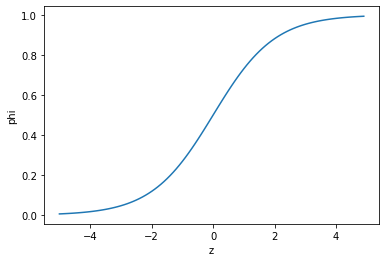

In [18]:
z = np.arange(-5 , 5 , 0.1)
phi = 1 / (1 + np.exp(-z))
plt.plot(z , phi)
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

> 0~1 의 값 

# 로지스틱 회귀로 이진 분류 해보기

> 0.5 이상이면 양성 클래스 이하면 음성 클래스

## 불리언 인덱싱 예제

In [19]:
char_arr = np.array(['A', 'B' , 'C' , 'D' , 'E'])
print(char_arr[[True, False, True, False, False]])

['A' 'C']


## 생선에 적용 (빙어만 골라내기)

In [20]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

In [22]:
lr = LogisticRegression()
lr.fit(train_bream_smelt , target_bream_smelt)

LogisticRegression()

In [23]:
print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


> 두번째 샘플 제외 모두 도미(Bream)로 예측

In [26]:
# 예측 확률 앞 5개
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


In [27]:
print(lr.classes_)

['Bream' 'Smelt']


> 사이킷런에서는 Bream이 양성 클래스

In [29]:
# 로지스틱 회귀가 학습한 계수 확인
print(lr.coef_, lr.intercept_)

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


> $ z = -0.404 \times (Weight) - 0.576 \times (Length) - 0.663 \times (Diagonal) - 1.013 \times (Height) - 0.732 \times (Width) -2.161 $

## z값 출력

In [30]:
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


> 이 z값을 시그모이드 함수에 통과시키면 확률을 얻을 수 있다. expit() : 시그모이드 함수 임포트 필요

In [32]:
print(expit(decisions))

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


# 로지스틱 회귀로 다중 분류 수행

> 반복적인 알고리즘 사용, max_iter 매개변수에서 반복 횟수를 지정하고 기본값은 100

> 계수의 제곱을 규제 (L2규제) , 매개변수 C 로 규제 제어 ( 작을수록 규제가 커짐 , 기본값 1)

In [33]:
lr = LogisticRegression(C=20 , max_iter=1000)
lr.fit(train_scaled , train_target)
print(lr.score(train_scaled , train_target))
print(lr.score(test_scaled , test_target))

0.9327731092436975
0.925


> 적당한거같다.

In [34]:
# 테스트 세트의 처음 5개 샘플에 대한 예측 출력
print(lr.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


In [35]:
# 테스트 세트의 처음 5개 샘플에 대한 예측 확률 출력
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba , decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


> 5개 샘플에 대한 예측이라 5개 행 출력

In [36]:
print(lr.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


> 첫번째 샘플은 Perch(농어) 를 가장 높은 확률로 예측

In [39]:
# coef_ 와 intercept_ 크기 출력
print(lr.coef_.shape , lr.intercept_.shape)

(7, 5) (7,)


> 다중 분류는 클래스마다 z 값을 하나씩 계산

> 소프트맥스 함수를 사용하여 7개의 z 값을 확률로 변환

### 소프트 맥스 함수 (임포트 필요)

$e_{sum}$ = $ e^{z1} + e^{z2} + e^{z3}+ e^{z4}+ e^{z5}+ e^{z6}+ e^{z7} $

$ s1 = \frac{e^{z1}}{e_{sum}}$ , $ s2 = \frac{e^{z2}}{e_{sum}}$ ,  $\dots$  ,  $ s7 = \frac{e^{z7}}{e_{sum}}$

In [40]:
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


In [42]:
proba = softmax(decision , axis=1)
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


> 로지스틱회귀랑 값이 같다.

_________

# **마무리**

`*` 키워드로 끝내는 핵심 포인트

`-` **로지스틱 회귀** : 선형 방정식을 사용한 분류 알고리즘입니다. 선형 회귀와 달리 시그모이드 함수나 소프트맥스 함수를 사용하여 클래스 확률을 출력할 수 있습니다.

`-` **다중 분류** : 타깃 클래스가 2개 이상인 분류 문제입니다. 로지스틱 회귀는 다중 분류를 위해 소프트맥스 함수를 사용하여 클래스를 예측합니다.


`-` **시그모이드 함수** : 선형 방정식의 출력을 0과 1 사이의 값으로 압축하며 이진 분류를 위해 사용합니다.


`-` **소프트맥스 함수** : 다중 분류에서 여러 선형 방정식의 출력 결과를 정규화하여 합이 1이 되도록 만듭니다.


`-` **핵심 패키지**

`-` scikit-learn

> `1` LogisticRegression : 선형 분류 알고리즘인 로지스틱 회귀를 위한 클래스입니다.\
\
solver 매개변수에서 사용할 알고리즘을 선택할 수 있습니다. 기본값은 '1bfgs'입니다. 사이킷런 0.17 버전에 추가된 'sag'는 확률적 평균 경사 하강법 알고리즘으로 특성과 샘플 수가 많을 때 성능은 빠르고 좋습니다. 사이킷런 0.19 버전에는 'sag'의 개선 버전인 'saga'가 추가되었습니다.\
\
penalty 매개변수에서 L2 규제 (릿지 방식)와 L1 규제 (라쏘 방식)를 선택할 수 있습니다. 기본값은 L2 규제를 의미하는 12 입니다.\
\
C 매개변수에서 규제의 강도를 제어합니다. 기본값은 1.0이며 값이 작을수록 규제가 강해집니다.
